<h1>Automated Flood Detection based on Satellite Images</h1>
<br>
This project focuses on flood detection using only the SEN2 data from the SEN12-FLOOD dataset. The goal is to process Sentinel-2 satellite images, specifically four spectral bands: Band2 (blue), Band3 (green), Band4 (red), and Band8 (infrared). These bands are important for distinguishing between land, water, and other surface features. The process involves organizing the data, checking for empty images, and stacking the bands together for further analysis, which will be used for flood detection tasks.
<br>
<hr>
Dataset:<br>
Clément Rambour, Nicolas Audebert, Elise Koeniguer, Bertrand Le Saux, Michel Crucianu, Mihai Datcu. (2020). SEN12-FLOOD : a SAR and Multispectral Dataset for Flood Detection . IEEE Dataport. https://dx.doi.org/10.21227/w6xz-s898

Download (after free registration) - 12,2Gb: https://ieee-dataport.org/open-access/sen12-flood-sar-and-multispectral-dataset-flood-detection


<h2>Import of used packages</h2>

Run the following command to install required packages:
'pip install rasterio opencv-python torch torchvision tifffile tensorflow matplotlib'

In [19]:
import rasterio
import os
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import tifffile as tiff  # TIFF fájlok betöltéséhez és kezeléséhez
import json
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import torch.nn.functional as F
import torchvision
import pytorch_lightning as pl
import torchmetrics
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.utils.data import WeightedRandomSampler
from pytorch_lightning import Trainer
import random
import pandas as pd
import gradio as gr
from PIL import Image
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

<h2>Directory and file setup</h2>

This function will check if the selected folder has a non-empty B02 file:

In [2]:
def check_img_content(path):
    
    path = os.path.join(path, 'B02.tif')

    # Load the image in grayscale mode (0)
    image = cv2.imread(path,0)
  
    # Return True if all pixels are zero (empty image), otherwise False
    if (cv2.countNonZero(image) == 0): return  True
    else: return  False

In [3]:
def remove_folders(path):
    # Delete the folder and all its contents
    shutil.rmtree(path)

This function performs a series of file structure modifications, to transform the downloaded data before processing. It will also throw away unused files and the original folders.

In [4]:
def create_dir_structure(flist):
    for folder in flist:
        prefix = folder[:11]    # Extract prefix from folder name
        id = folder[11:]        # Extract id from folder name

        if len(id) > 4: continue # Skip if id length is more than 4, because the id can be at most 4 digits

        for file in os.listdir(folder):

            if file.startswith('S1'): 
                os.remove(os.path.join(prefix + id, file)) # Remove files starting with 'S1'
                continue

            # If the file is a spectral band (B02, B03, B04, B08)
            if file.endswith('B02.tif') or file.endswith('B03.tif') or file.endswith('B04.tif') or file.endswith('B08.tif'):
                date = file[3:13] # Extract date from file name
                newFolder =  os.path.join(prefix,'S2_' + id + '_'+ date) # Create new folder name

                if os.path.isdir(newFolder):
                    shutil.move(os.path.join(folder, file), os.path.join(newFolder, file[14:])) # Move file if folder exists
                    
                else:
                    os.mkdir(newFolder)     # Create folder if it doesn't exist
                    shutil.move(os.path.join(folder, file), os.path.join(newFolder, file[14:]))  # Move file

        remove_folders(folder) # Remove the original folder after moving files


This function will stack the 4 image bands into 1 output file, which will be used for training and testing:

In [5]:
def stack_bands(path):

    band_list = ['B02.tif', 'B03.tif', 'B04.tif', 'B08.tif']
    try:
        
        # Read metadata from the first band (B02.tif) 
        with rasterio.open(os.path.join(path, band_list[0])) as src0:
            meta = src0.meta # Extract metadata from the first band
        
        # Update metadata to reflect the number of bands (layers) 
        meta.update(count = len(band_list))

       # Create a new stack file and write each band to it
        with rasterio.open(os.path.join(path, 'stack.tif'), 'w', **meta) as dst:
            for id, layer in enumerate(band_list, start=1):
                with rasterio.open(os.path.join(path, layer)) as src1:
                    dst.write_band(id, src1.read(1)) # Write each band to the stack file
    except:
        print("Folder with no Data") # Handle cases where the folder has no valid data 
        remove_folders(path) # Remove the folder if there's an issue
        
        pass # Continue without stopping on error 

Read and store the folder list:

In [6]:
folderList = []

rootdir = os.path.normpath('./SEN12FLOOD')  # Get the absolute path for the root directory
#rootdir = './SEN12FLOOD' 
for file in os.listdir(rootdir):
    d = os.path.join(rootdir, file) # Create the full path for each file/folder
    if os.path.isdir(d):    # Check if it's a folder
        folderList.append(d)     # Add folder to the list
        
# Print the total number of folders found        
print(f"The number of folders are currently = {len(folderList)}")

The number of folders are currently = 2039


Based on the original folder list, create the new structure. The function will ignore already transformed folders, running multiple times is safe.

In [7]:
# Call the function to create the directory structure for the initial folder list (can run up to 1-2 min)
create_dir_structure(folderList)

Read and store the updated folder list:

In [4]:
folderList = []
#rootdir = './SEN12FLOOD'
rootdir = os.path.normpath('./SEN12FLOOD')
for file in os.listdir(rootdir):
     if 'S2_' in file:
        d = os.path.join(rootdir, file)
        if os.path.isdir(d):
            folderList.append(d)
        
print(f"The number of folders are currently = {len(folderList)}")


The number of folders are currently = 2039


Based on the updated folder list, stack the selected bands:

In [9]:
#Iterate through all folders and create a new image with 4 spectral bands:
#Band2 (blue), Band3 (green), Band4 (red), and Band8 (infrared)
#This process can take up to 2-5 minutes to complete

for folder_path in folderList:
    empty = check_img_content(folder_path) # Check if the folder contains empty images (all pixels are zero)
    if empty:
        
        print("The images inside the current folder are empty - zero")
        remove_folders(folder_path) # Remove the folder if images are empty 
    else:
        stack_bands(folder_path) # Stack the spectral bands if images are valid

<h2>JSON Metadata Processing</h2>

Load the JSON content into the 'data' variable:

In [10]:
with open('./SEN12FLOOD/S2list.json', 'r') as file:
    data = json.load(file)

print( data)

{'0063': {'1': {'date': '2019-02-04', 'FLOODING': False, 'FULL-DATA-COVERAGE': True, 'filename': 'S2_2019-02-04'}, 'count': 1, 'folder': '0063', 'geo': {'type': 'Polygon', 'coordinates': [[[28.29722, -15.382762], [28.297507, -15.429039], [28.345216, -15.428755], [28.344918, -15.382479], [28.29722, -15.382762]]]}}, '0200': {'1': {'date': '2019-02-23', 'FLOODING': False, 'FULL-DATA-COVERAGE': True, 'filename': 'S2_2019-02-23'}, '2': {'date': '2019-02-28', 'FLOODING': False, 'FULL-DATA-COVERAGE': True, 'filename': 'S2_2019-02-28'}, '3': {'date': '2019-03-10', 'FLOODING': False, 'FULL-DATA-COVERAGE': True, 'filename': 'S2_2019-03-10'}, '4': {'date': '2019-03-25', 'FLOODING': True, 'FULL-DATA-COVERAGE': True, 'filename': 'S2_2019-03-25'}, '5': {'date': '2019-04-04', 'FLOODING': True, 'FULL-DATA-COVERAGE': True, 'filename': 'S2_2019-04-04'}, '6': {'date': '2019-04-14', 'FLOODING': True, 'FULL-DATA-COVERAGE': True, 'filename': 'S2_2019-04-14'}, '7': {'date': '2019-04-24', 'FLOODING': True, 'F

Iterate through the JSON structure, and write the FLOODING boolean attribute into the 'flooding.txt' file in each corresponfing folder:

In [11]:
for location_id, location_data in data.items():
    for location_date, date_data in location_data.items():
        if location_date == 'geo' or location_date =='count' or location_date =='folder': continue
        folder = os.path.join(rootdir, 'S2_' + location_id + '_' + date_data['date'])
        file = os.path.join(folder, 'flooding.txt')

        if os.path.isdir(folder):
            with open(file, 'w') as f:
                f.write(f"{date_data['FLOODING']}\n")

<h2>Data Augmentation</h2>

Composition of used transformations:

In [37]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(brightness=0.2, contrast=0.5, saturation=0.5, hue=0.3),
    transforms.RandomRotation(degrees=15),
    #transforms.RandomPerspective(distortion_scale=0.5, p=0.5) #perspektív torzítás
    #transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)) #homályosítás

])

Applying the augmentation and creating the new files:

In [ ]:
def augment_images_in_directory(input_dir):
    # Iterate through files in the specified directory
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file == 'stack.tif':  # Focus only on 'stack.tif' images
                file_path = os.path.join(root, file)
                
                # Load TIFF image with 4 channels (HxWxC)
                img = tiff.imread(file_path)
                
                # Convert image to tensor and rearrange to (CxHxW format for PyTorch)
                img_tensor = torch.from_numpy(img).permute(2, 0, 1).float()
                # Apply augmentation
                img_transformed = train_transform(img_tensor)
                
                # Convert image back to (HxWxC format for numpy)
                img_transformed = img_transformed.permute(1, 2, 0).numpy().astype(np.uint16)
                
                # Save augmented image with new name: 'astack.tif'
                save_path = os.path.join(root, 'astack.tif')
                tiff.imwrite(save_path, img_transformed)

# Main execution
input_directory = './SEN12FLOOD'  # Root directory where the folders are located
augment_images_in_directory(input_directory)

torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([

<h2>Data loading</h2>

The getLabel function will return 0 or 1, depending whether the folder on 'path' contains FLOODED images or not:

We can define the train-test split ratio and the shuffle seed here:

Shuffle and split the folder list into separate folder lists for training and testing:

In [ ]:
# Set random seed for reproducibility
random.seed(42)

# Function to get labels from text file
def getLabel(path):
    filepath = os.path.normpath(os.path.join(path, 'flooding.txt'))
    with open(filepath, 'r') as file:
        data = file.readline().strip()
        return 0 if data == "False" else 1

# Data loading setup
train_size = 0.7
shuffle_seed = 42

folderList = []
rootdir = os.path.normpath('./SEN12FLOOD')
for file in os.listdir(rootdir):
    if 'S2_' in file:
        d = os.path.join(rootdir, file)
        if os.path.isdir(d):
            folderList.append(d)

size = len(folderList)
print(f"The number of folders are currently = {size}")

# Shuffle the data
random.shuffle(folderList)

test_start = round(size * train_size)
train_list = folderList[:test_start]
test_list = folderList[test_start:]

print(f"The number of folders for training are currently = {len(train_list)}")
print(f"The number of folders for testing are currently = {len(test_list)}")


The number of folders are currently = 2039
The number of folders for training are currently = 1427
The number of folders for testing are currently = 612


In [39]:
# 65535 a legnagyobb érték, amit ki tud adni a 16 bites kép
normalizer = 65535.0

The load data function create the format necessary for further processing, based on train_list and test_list:

In [43]:
def load_data():
    images_train = []
    labels_train = []
    images_test = []
    labels_test = []

    # Load training data
    for folder in train_list:
        
        label = getLabel(folder)
        # Add original image
        imagePath = os.path.join(folder, "stack.tif")
        image = tiff.imread(imagePath)
        if image is not None:
            images_train.append(image)
            labels_train.append(label)

            
        # Add augmented image
        imagePath = os.path.join(folder, "astack.tif")
        image = tiff.imread(imagePath)
        if image is not None:
            images_train.append(image)
            labels_train.append(label)


    # Load test data
    for folder in test_list:
        # Add original image
        imagePath = os.path.join(folder, "stack.tif")
        image = tiff.imread(imagePath)
        if image is not None:
            images_test.append(image)
            # Add label
            label = getLabel(folder)
            labels_test.append(label)

    # Convert to numpy arrays and normalize
    images_train = np.array(images_train, dtype='float32') / normalizer  # Augmentation applied as unit16, so normalize to float32
    labels_train = np.array(labels_train, dtype='int64')
    images_test = np.array(images_test, dtype='float32') / normalizer  # Augmentation applied as unit16, so normalize to float32 
    labels_test = np.array(labels_test, dtype='int64')

    return images_train, images_test, labels_train, labels_test
    

Load the data into X and y train and test arrays:

In [44]:
X_train, X_test, y_train, y_test = load_data()

Notice that X_train has double the rows as the training folders, as both the original and the augmented image is added.
Meanwhile the test data has the same number of rows as the test folder count:

In [45]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(2854, 512, 512, 4)
(2854,)
(612, 512, 512, 4)
(612,)


<h2>Data Analysis</h2>

This function prints information on the distribution of FLOODED and CLEAR data:

In [13]:
band_names = ["Blue", "Green", "Red", "NIR"]

In [ ]:
def analyzeLabels(labels):
    (unique, counts) = np.unique(labels, return_counts=True)

    print(f"FLOODED - images containing flooded areas in this dataset: {counts[1]}\n")
    print(f"CLEAR - images containing clear areas in this dataset: {counts[0]}\n")
    percentage = round(counts[1] / (counts[0] + counts[1]) * 100, 3)
    print(f"Percentage of FLOODED areas: " + str(percentage) + "%")

In [ ]:
def analyze_band_contributions(band_paths, stack_path):

    analysis = {}

    with rasterio.open(stack_path) as stack_src:
        stacked_data = stack_src.read()
        total_stack_sum = stacked_data.sum()

    for i, band_path in enumerate(band_paths):
        band_name = band_names[i] 

        with rasterio.open(band_path) as band_src:
            band_data = band_src.read(1)
     
        if stacked_data.shape[1:] != band_data.shape:
            raise ValueError(f"Shape mismatch for {band_name}: {band_data.shape} vs stack {stacked_data.shape[1:]}")

        band_sum = band_data.sum()
        contribution_ratio = band_sum / total_stack_sum

        analysis[band_name] = {
            "sum": band_sum,
            "contribution_ratio": contribution_ratio
        }

    return analysis


In [ ]:
def analyze_bands_in_folders(folder_list):

    analysis_results = {}

    for folder in folder_list:
        folder_name = os.path.basename(folder)

        band_paths = [os.path.join(folder, band) for band in ['B02.tif', 'B03.tif', 'B04.tif', 'B08.tif']]
        stack_path = os.path.join(folder, "stack.tif")
        
        if not os.path.exists(stack_path):
            print(f"Warning: Stack file not found in {folder}")
            continue
        if not all(os.path.exists(band_path) for band_path in band_paths):
            print(f"Warning: Not all band files are present in {folder}")
            continue

        try:
            analysis = analyze_band_contributions(band_paths, stack_path)
            analysis_results[folder_name] = analysis
        except Exception as e:
            print(f"Error processing folder {folder_name}: {e}")

    return analysis_results


In [ ]:
def aggregate_contribution_results(results):

    data = []
    
    for folder, bands in results.items():
        for band, stats in bands.items():
            data.append({
                "Folder": folder,
                "Band": band,
                "Contribution Ratio": stats["contribution_ratio"]
            })

    df = pd.DataFrame(data)

    aggregated_df = df.groupby("Band").agg(
        Mean_Contribution=("Contribution Ratio", "mean"),
        Std_Contribution=("Contribution Ratio", "std")
    ).reset_index()

    return aggregated_df


In [ ]:
def visualize_contribution_pie_chart(aggregated_df):

    bands = aggregated_df["Band"]
    contributions = aggregated_df["Mean_Contribution"]

    plt.figure(figsize=(8, 8))
    wedges, texts, autotexts = plt.pie(
        contributions, 
        labels=bands, 
        autopct=lambda p: f"{p:.1f}%",
        startangle=90, 
        colors=['blue', 'green', 'purple', 'red'],
        textprops={'fontsize': 12} 
    )

    plt.title("Band Contribution Ratios (Pie Chart)", fontsize=14)

    for autotext in autotexts:
        autotext.set_color('white') 
        autotext.set_fontsize(10)

    plt.show()



Training data analysis:

In [ ]:
analyzeLabels(y_train)

FLOODED - images containing flooded areas in this dataset: 668

CLEAR - images containing clear areas in this dataset: 2186

Percentage of FLOODED areas: 23.406%


Test data analysis:

In [ ]:
analyzeLabels(y_test)

FLOODED - images containing flooded areas in this dataset: 135

CLEAR - images containing clear areas in this dataset: 477

Percentage of FLOODED areas: 22.059%


In [ ]:
results = analyze_bands_in_folders(folderList)

aggregated_results = aggregate_contribution_results(results)

print(aggregated_results)

    Band  Mean_Contribution  Std_Contribution
0   Blue           0.145687          0.047117
1  Green           0.195453          0.037491
2    NIR           0.455194          0.118846
3    Red           0.203666          0.048612


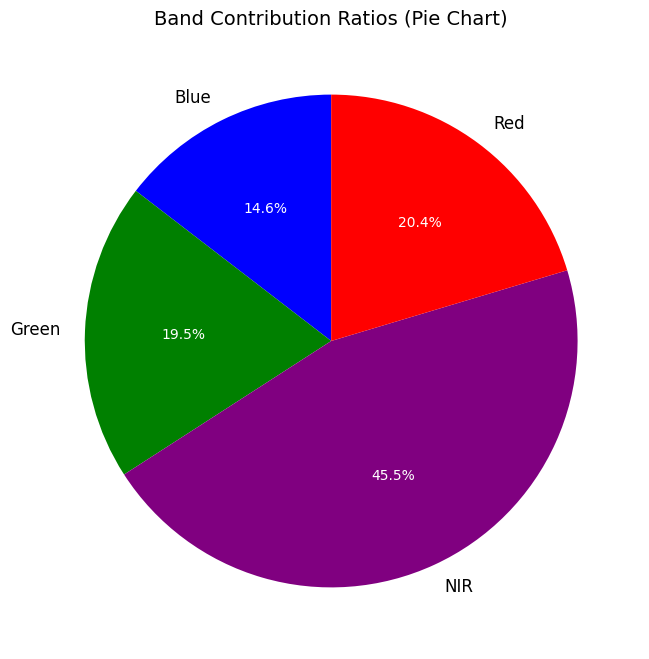

In [ ]:
visualize_contribution_pie_chart(aggregated_results)

# Modell

In [49]:
# Define custom dataset class
class FloodDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406, 0.406], std=[0.229, 0.224, 0.225, 0.225]),
])

val_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406, 0.406], std=[0.229, 0.224, 0.225, 0.225]),
])

In [50]:
class_counts = [2186, 668]  # Clear, Flooded
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)
sample_weights = [class_weights[label] for label in y_train]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(y_train), replacement=True)


In [59]:
# Create datasets and dataloaders
train_dataset = FloodDataset(X_train, y_train, transform=train_transform)
val_dataset = FloodDataset(X_test, y_test, transform=val_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=0, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

# Define a custom CNN model
class CustomCNN(torch.nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1_input_dim = None  # This will be dynamically computed
        self.fc1 = None  # Placeholder for fully connected layer
        self.dropout = torch.nn.Dropout(0.3)
        self.fc2 = torch.nn.Linear(64, 2)  # Output layer
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = torch.flatten(x, 1)  # Flatten dynamically based on the batch size
        
        # Dynamically calculate fc1_input_dim and define fc1 if not already defined
        if self.fc1 is None:
            self.fc1_input_dim = x.shape[1]  # Calculate input dimension dynamically
            self.fc1 = torch.nn.Linear(self.fc1_input_dim, 64)  # Define fc1 with correct input dimension
            self.fc1 = self.fc1.to(x.device)  # Move fc1 to the appropriate device

        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# Xavier initialization function
def init_weights(m):
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:  # If bias exists, initialize it to zero
            torch.nn.init.constant_(m.bias, 0)

# Instantiate the custom model
model = CustomCNN()

model.apply(init_weights)

# Define Lightning module
class FloodClassifier(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=2)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        cross_weights = torch.tensor([1.305,4.274],dtype = torch.float32).to(self.device)
        pred_labels = self(images)
        loss = F.cross_entropy(pred_labels, labels, weight = cross_weights)
        acc = self.accuracy(pred_labels, labels)
        self.log('train_loss', loss)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        pred_labels = self(images)
        loss = F.cross_entropy(pred_labels, labels)
        acc = self.accuracy(pred_labels, labels)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',
            }
        }


In [52]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validációs veszteséget
    patience=3,          # Ha 3 egymást követő epoch során nincs javulás, megállítja a tréninget
    verbose=True,
    mode='min'           # Minimalizálja a validációs veszteséget
)

In [53]:
# Train the model
flood_model = FloodClassifier(model)
trainer = pl.Trainer(
    max_epochs=20,
    accelerator='cpu',
    callbacks=[early_stopping]  # Hozzáadjuk az Early Stopping callback-et
)
trainer.fit(flood_model, train_loader, val_loader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\totha\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model    | CustomCNN          | 5.5 K  | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
5.5 K     Trainable params
0         Non-trainable params
5.5 K     Total params
0.022     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\totha\AppData\Roaming\Python\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


C:\Users\totha\AppData\Roaming\Python\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0:  59%|█████▉    | 53/90 [00:59<00:41,  0.88it/s, v_num=1, train_acc=0.531]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

Created dataset file at: .gradio\flagged\dataset1.csv


In [ ]:
model_path = "flood_model.pth"
torch.save(flood_model.model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to flood_model.pth


Gradioba be lehet dobni képet, amit leosztályoz egy webes felületen. A képet nem tudja megjeleníteni, mert 4 csatornás és megbolondul tőle.

In [56]:
# Import required libraries
import gradio as gr
import torch
import torchvision.transforms as transforms
import numpy as np
import cv2
from PIL import Image

# Load the trained model
model = CustomCNN()
model.load_state_dict(torch.load("flood_model.pth"), strict=False)  
model.eval()

# Define the transform to preprocess the image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406, 0.406], std=[0.229, 0.224, 0.225, 0.225]),
])

# Class labels
class_labels = ["CLEAR", "FLOODED"]

def classify_and_display_image(image_path):
    """Classify the uploaded image as CLEAR or FLOODED and return the image."""
    # Read file and handle as tensor
    image = cv2.imread(image_path.name, cv2.IMREAD_UNCHANGED)
    if image is None:
        return None, "Error: Unable to read image file."

    # If the image is grayscale, replicate it to match 4-channel input
    if len(image.shape) == 2:
        image = np.stack([image] * 4, axis=-1)

    # Normalize the pixel values for model compatibility
    image = image.astype('float32') / 65535.0

    # Convert to a tensor and apply transformations
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Perform inference
    with torch.no_grad():
        output = model(image_tensor)
        predicted_class = torch.argmax(output, dim=1).item()

    # Convert the image to PIL format for visualization
    image_to_display = Image.fromarray((image[..., :3] * 255).astype(np.uint8))  # Use the first 3 channels (RGB)

    # Return the image and classification label
    return image_to_display, class_labels[predicted_class]

# Gradio interface
interface = gr.Interface(
    fn=classify_and_display_image,
    inputs=gr.File(label="Upload a TIFF Image"),
    outputs=[
        gr.Image(type="pil", label="Uploaded Image"),  # Updated from gr.outputs.Image
        gr.Textbox(label="Classification Result")      # Updated from gr.outputs.Textbox
    ],
    title="Flood Classifier",
    description="Upload a TIFF image to classify it as CLEAR or FLOODED, and view the image."
)

# Launch the interface
interface.launch()


C:\Users\totha\AppData\Local\Temp\ipykernel_22568\2271368823.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("flood_model.pth"), strict

* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


Az összes képet leosztályozza és egy csv-be kiírja az osztályozást és a valós osztályt

In [57]:
# Load the trained model
model = CustomCNN()
model.load_state_dict(torch.load("flood_model.pth"), strict = False)  # Adjust path as needed
model.eval()

# Define the transform to preprocess the image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406, 0.406], std=[0.229, 0.224, 0.225, 0.225]),
])

# Class labels
class_labels = ["CLEAR", "FLOODED"]

# Helper function to classify an image
def classify_image(image):
    # Normalize TIFF pixel values to [0, 1]
    if image.max() > 1.0:  # Ensure normalization is needed
        image = image.astype('float32') / 65535.0

    # Apply transforms
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Perform inference
    with torch.no_grad():
        output = model(image_tensor)
        predicted_class = torch.argmax(output, dim=1).item()
        return class_labels[predicted_class]

def evaluate_loaded_data(folder_list, test_list):
    results = []

    for folder in test_list:
        # Load original image
        image_path = os.path.join(folder, "stack.tif")
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED | cv2.IMREAD_ANYDEPTH)
        if image is None:
            results.append({
                "folder": folder,
                "predicted_class": "Error: Image not found",
                "true_class": "Unknown"
            })
            continue

        # Ensure the image has 4 channels
        if len(image.shape) == 2:
            image = np.stack([image] * 4, axis=-1)

        # Get true class
        true_class = "FLOODED" if getLabel(folder) == 1 else "CLEAR"

        # Predict class
        predicted_class = classify_image(image)

        # Save result
        results.append({
            "folder": folder,
            "predicted_class": predicted_class,
            "true_class": true_class
        })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Example usage
def main():
    folder_list = []
    rootdir = os.path.normpath('./SEN12FLOOD')
    for file in os.listdir(rootdir):
        if 'S2_' in file:
            d = os.path.join(rootdir, file)
            if os.path.isdir(d):
                folder_list.append(d)

    size = len(folder_list)
    train_size = 0.7
    test_start = round(size * train_size)

    train_list = folder_list[:test_start]
    test_list = folder_list[test_start:]

    # Evaluate the test set
    results_df = evaluate_loaded_data(folder_list, test_list)

    # Save the results to a CSV file
    results_df.to_csv("classification_results.csv", index=False)
    print("Classification results saved to classification_results.csv")

if __name__ == "__main__":
    main()

C:\Users\totha\AppData\Local\Temp\ipykernel_22568\658759633.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("flood_model.pth"), strict =

Classification results saved to classification_results.csv


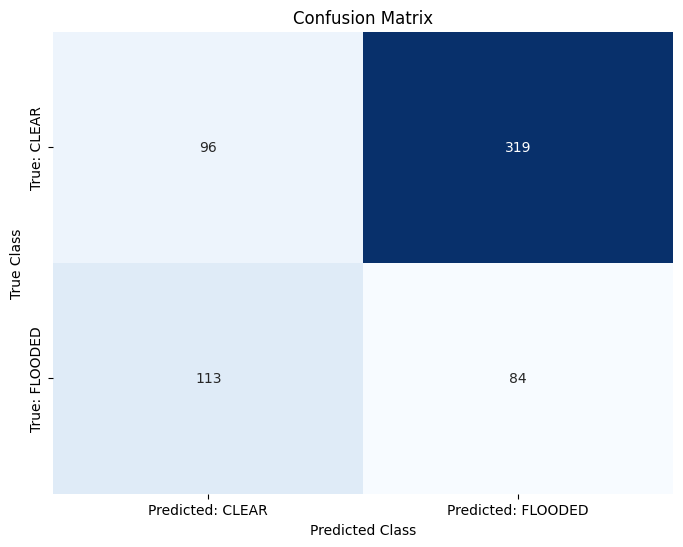

In [21]:
data = pd.read_csv("classification_results.csv")
tp = ((data['predicted_class'] == "FLOODED") & (data['true_class'] == "FLOODED")).sum()
tn = ((data['predicted_class'] == "CLEAR") & (data['true_class'] == "CLEAR")).sum()
fp = ((data['predicted_class'] == "FLOODED") & (data['true_class'] == "CLEAR")).sum()
fn = ((data['predicted_class'] == "CLEAR") & (data['true_class'] == "FLOODED")).sum()


conf_matrix = pd.DataFrame([[tn, fp], [fn, tp]],
                           columns=["Predicted: CLEAR", "Predicted: FLOODED"],
                           index=["True: CLEAR", "True: FLOODED"])


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

In [22]:
class_counts = data['true_class'].value_counts()
total_samples = len(data)

for class_name, count in class_counts.items():
    balance = count / total_samples
    print(f"Class '{class_name}' Balance: {balance:.2f}")

Class 'CLEAR' Balance: 0.68
Class 'FLOODED' Balance: 0.32


In [23]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0


print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1_score:.2f}")


summary = pd.DataFrame({
    "Metric": ["True Positives", "True Negatives", "False Positives", "False Negatives"],
    "Count": [tp, tn, fp, fn]
})
print("\nConfusion Matrix:")
print(summary)


y_true = data['true_class']
y_pred = data['predicted_class']
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["CLEAR", "FLOODED"], zero_division=0))


Accuracy: 0.29
Precision: 0.21
Recall: 0.43
F1-Score: 0.28

Confusion Matrix:
            Metric  Count
0   True Positives     84
1   True Negatives     96
2  False Positives    319
3  False Negatives    113

Classification Report:
              precision    recall  f1-score   support

       CLEAR       0.46      0.23      0.31       415
     FLOODED       0.21      0.43      0.28       197

    accuracy                           0.29       612
   macro avg       0.33      0.33      0.29       612
weighted avg       0.38      0.29      0.30       612



#### Metrikák rövid összefoglalása:
- **Accuracy:** Az összes helyesen osztályozott minta aránya az összes mintához képest.
- **Precision:** Az összes pozitív előrejelzés közül hány volt helyes (a téves riasztások elkerülésének mértéke).
- **Recall (Sensitivity):** A valódi pozitív esetek közül hányat talált meg a modell (az érzékenység mutatója).
- **F1-Score:** A Precision és a Recall harmonikus átlaga, kiegyensúlyozott teljesítménymutató.

#### Átlagolási módszerek:
- **Macro Average:** Az összes osztály metrikájának egyszerű (nem súlyozott) átlaga, függetlenül az osztályok méretétől.
- **Weighted Average:** Az osztályok metrikáinak súlyozott átlaga, amely figyelembe veszi az egyes osztályok példáinak arányát az adathalmazban.


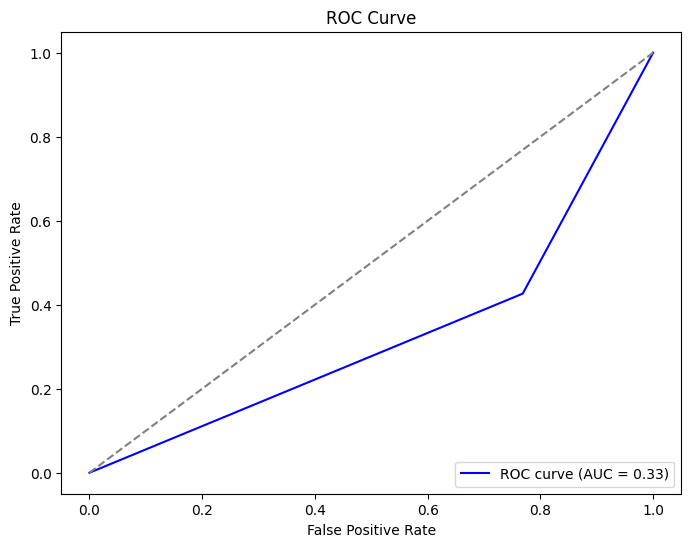

In [24]:
data['true_class_binary'] = (data['true_class'] == "FLOODED").astype(int)
data['predicted_prob'] = data['predicted_class'].apply(lambda x: 1 if x == "FLOODED" else 0)


fpr, tpr, thresholds = roc_curve(data['true_class_binary'], data['predicted_prob'])
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

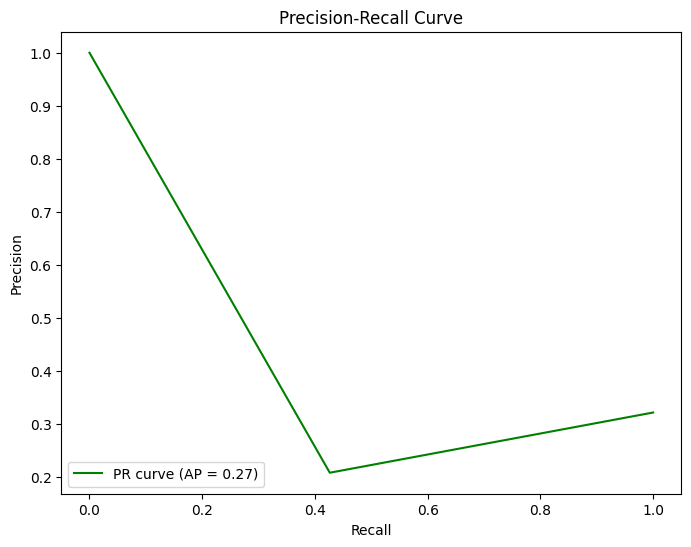

In [25]:
precision, recall, thresholds = precision_recall_curve(data['true_class_binary'], data['predicted_prob'])
average_precision = average_precision_score(data['true_class_binary'], data['predicted_prob'])


plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label=f'PR curve (AP = {average_precision:.2f})')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.show()